In [ ]:
# Bagian 1: Import Libraries dan Load Dataset
!pip install emoji
!pip install Sastrawi

from flask import Flask, request, jsonify
import nltk
import pandas as pd
import re
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
data = pd.read_csv('/content/sentiment_analysis.csv')
print("Shape of the dataset:")
print(data.shape)
print(data.dtypes)
print(data.head(2800))

Shape of the dataset:
(3245, 9)
event_id            int64
category_id         int64
user_id             int64
user_name          object
user_past_event    object
review_id           int64
rating              int64
date               object
text               object
dtype: object
      event_id  category_id  user_id      user_name user_past_event  \
0          122            2        3   Fandi Wijaya            6, 1   
1         3168            1      185    Budi Wijaya            6, 3   
2         1638            6       73   Hadi Santoso            6, 3   
3         1649            6      190  Fajar Santoso            1, 3   
4         1423            4       32   Ani Setiawan            6, 3   
...        ...          ...      ...            ...             ...   
2795      3356            3      146   Rudi Susanto            6, 1   
2796      1638            6       65   Siti Pratama            5, 6   
2797      1417            4       76  Sinta Hidayat            3, 2   
2798      

Text(0.5, 0, 'Review rating')

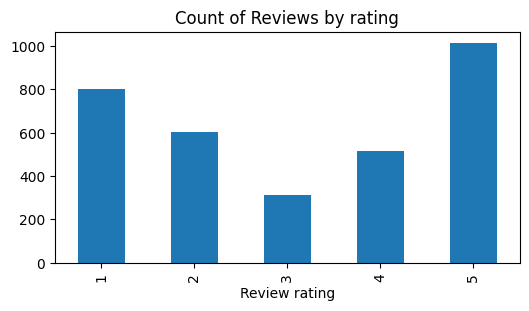

In [ ]:
ax = data['rating'].value_counts().sort_index().plot(kind='bar',
          title='Count of Reviews by rating',
          figsize=(6, 3))
ax.set_xlabel('Review rating')

In [ ]:
#Preprocessing dan Feature Extraction
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[?|$|.|!_:")(-+,]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r"\b[a-zA-Z]\b", "", text)
        text = re.sub('\s+',' ', text)
        text = nltk.word_tokenize(text)
        stop_words = set(stopwords.words('indonesian'))
        text = [word for word in text if word.lower() not in stop_words]
        factory = StemmerFactory()
        stemmer = factory.create_stemmer()
        text = [stemmer.stem(w) for w in text]
        return ' '.join(text)
    else:
        return ''

In [ ]:
data['processed_text'] = data['text'].apply(preprocess_text)

In [ ]:
sid = SentimentIntensityAnalyzer()
data['vader_sentiment'] = data['processed_text'].apply(lambda x: 'positive' if sid.polarity_scores(x)['compound'] >= 0.05 else ('negative' if sid.polarity_scores(x)['compound'] <= -0.05 else 'neutral'))
# Feature Extraction menggunakan CountVectorizer
vocab = CountVectorizer().fit(data['processed_text'])
x = vocab.transform(data['processed_text'])

In [ ]:
#Pembagian Data dan Model Training
x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(x, data['rating'], data['vader_sentiment'], test_size=0.2, random_state=100)


In [ ]:
# Parameter tuning for Multinomial Naive Bayes
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid_search.fit(x_train, y_train)
best_mnb = grid_search.best_estimator_

In [ ]:
# Use TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer().fit(data['processed_text'])
x_tfidf = tfidf_vectorizer.transform(data['processed_text'])
x_train_tfidf, x_test_tfidf, _, _, _, _ = train_test_split(x_tfidf, data['rating'], data['vader_sentiment'], test_size=0.2, random_state=100)


In [ ]:
# Retrain the model with TF-IDF vectorization
best_mnb_tfidf = grid_search.best_estimator_
best_mnb_tfidf.fit(x_train_tfidf, y_train)
pred_mnb_tfidf = best_mnb_tfidf.predict(x_test_tfidf)

In [ ]:
# Evaluate the model
score_mnb_tfidf = round(accuracy_score(y_test, pred_mnb_tfidf) * 100, 2)
print("Confusion Matrix for Multinomial Naive Bayes (TF-IDF):")
print(confusion_matrix(y_test, pred_mnb_tfidf))
print("Score (TF-IDF):", score_mnb_tfidf)
print("Classification Report (TF-IDF):")
print(classification_report(y_test, pred_mnb_tfidf))

Confusion Matrix for Multinomial Naive Bayes (TF-IDF):
[[134   2   0   0   5]
 [ 78  10   0   2  35]
 [ 26   3   0   4  38]
 [  2   0   0   9  85]
 [  3   0   0   3 210]]
Score (TF-IDF): 55.93
Classification Report (TF-IDF):
              precision    recall  f1-score   support

           1       0.55      0.95      0.70       141
           2       0.67      0.08      0.14       125
           3       0.00      0.00      0.00        71
           4       0.50      0.09      0.16        96
           5       0.56      0.97      0.71       216

    accuracy                           0.56       649
   macro avg       0.46      0.42      0.34       649
weighted avg       0.51      0.56      0.44       649



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def predict_sentiment(review):
    processed_review = preprocess_text(review)
    review_vectorized = vocab.transform([processed_review])
    sentiment_score = sid.polarity_scores(processed_review)['compound']
    rating_prediction = best_mnb.predict(review_vectorized)[0]
    if sentiment_score <= -0.05:
        predicted_sentiment = 'negative'
    elif sentiment_score >= 0.05:
        predicted_sentiment = 'positive'
    else:
        predicted_sentiment = 'neutral'
    return rating_prediction, predicted_sentiment

In [ ]:
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    review = request.json['review']
    rating_prediction, sentiment_prediction = predict_sentiment(review)
    return jsonify({'rating': rating_prediction, 'sentiment': sentiment_prediction})

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [ ]:
# Model Before Flask
def predict_sentiment(review):
    processed_review = preprocess_text(review)
    review_vectorized = vocab.transform([processed_review])
    sentiment_score = sid.polarity_scores(processed_review)['compound']
    rating_prediction = best_mnb_tfidf.predict(review_vectorized)[0]
    if sentiment_score <= -0.05:
        predicted_sentiment = 'negative'
    elif sentiment_score >= 0.05:
        predicted_sentiment = 'positive'
    else:
        predicted_sentiment = 'neutral'
    return rating_prediction, predicted_sentiment

In [ ]:
pr = data['text'][120]
print(pr)
print("Actual Rating:", data['rating'][2999])
rating_pred, sentiment_pred = predict_sentiment(pr)
print("Predicted Rating:", rating_pred)
print("Predicted Sentiment:", sentiment_pred)


Ada apa ini traveloka error kah? Kenapa saya gk bisa melakukan pembayaran menggunakan paylater padahal limit saya masih banyak...
Actual Rating: 1
Predicted Rating: 1
Predicted Sentiment: negative
